# Data Cleaning & Feature Extraction

In this notebook, load the different data sources explored earlier and clean them for our approaches. We will then create a very basic predicition system to check for 

In [1]:
import pandas as pd
import numpy as np
import sys, os
import sys
sys.path.insert(1, '..')
import recommender as rcmd
%matplotlib inline

Next we will load a set of relevant data sources

In [2]:
nf = rcmd.news.FPNewsFeed('https://www.ft.com/business-education?format=rss', col_map={'link': 'article_link', 'summary': 'summary', 'title': 'headline', 'published': 'date'}, filter=True)
news_meta, df_news = nf.news()
sm = rcmd.stocks.FMPStatements()
tk = rcmd.stocks.AlphaVantageTicker()
df_stocks = rcmd.contrib.fmp_api.profile.list_symbols()

In [30]:
df_stocks['symbol'].values

array(['SPY', 'CMCSA', 'KMI', ..., 'ZWZZT', 'ZXZZT', 'ZYME'], dtype=object)

## Data Extraction Pipeline

Our goal will be to create a pipeline that can extract data for a specific stock we select from `df_stocks`. This includes the last balance-sheet statements as well as historic stock prices. We should also search for historic news that we can use for the training process.

In [38]:
def find_stock(name, stocks):
    return stocks[stocks['name'].str.contains(name, case=False)]

find_stock('facebook', df_stocks)

,name,price,symbol
21,Facebook Inc.,188.2,FB


In [57]:
# some stock selection functions (this gathers all available data and might take a while...)
#df = sm.merge_records(df_stocks['symbol'].values)
#df.to_csv('../data/statements.csv')

# load the relevant data
df = pd.read_csv('../data/statements.csv')

In [61]:
# create an index based on year and quarter
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df['year'] = df['date'].dt.year
df['quarter'] = df['date'].dt.quarter

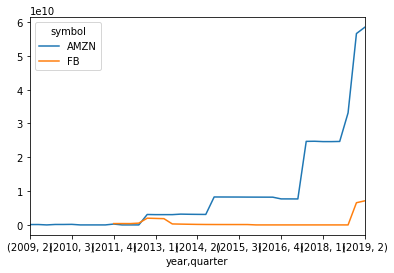

In [76]:
# print out example data
def get_feature(symbol, feat):
    return df[df['symbol'] == symbol].set_index(['year', 'quarter'])[feat].rename(symbol).sort_index(ascending=True)

def get_features(symbols, feat):
    return df[df['symbol'].isin(symbols)].pivot_table(index=['year', 'quarter'], columns='symbol', values=feat).sort_index(ascending=True)

# plot features
get_features(['FB', 'AMZN'], 'debt_longterm').plot()

**Stock Data**

Now that we have loaded the relevant Stock Statements, lets load the historical stock data (daily resolution) - in this case loading from file (requires that the `data/download_stocks.sh` script has been executed.

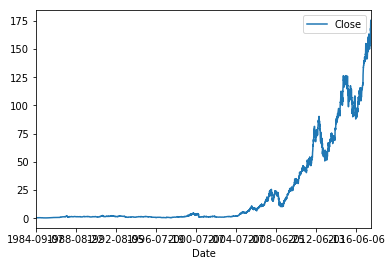

In [19]:
import glob
import os
def list_stocks(type='stock'):
    '''Generates a list of available historic stock data.'''
    fldr = 'Stocks' if type == 'stock' else 'ETFs'
    path = '../data/{}'.format(fldr)
    # list all fiels in direcotry
    files = glob.glob(os.path.join(path, '*.txt'))
    names = pd.Series(files).apply(lambda f: os.path.basename(f).split('.')[0])
    #return pd.DataFrame({'symbol': names, 'file': files})
    return dict(zip(names, files))

def load_stock_file(file, type='stock'):
    # list all fiels in direcotry
    return pd.read_csv(file)
    
stocks = list_stocks('stock')
#stocks
dfa = pd.read_csv(stocks['aapl'])
dfa.set_index('Date')[['Close']].plot();

In [ ]:
# TODO: select historic news and scrap entire news articles? + Use Embeddings to integrate them

## Feature Extraction

After we have loaded the data and can extract relevant portions, we want to convert it into training data. This requires data to have a single embedding and to use structured time information. As well as combine past data with future performance to have labels for the training process.

We will use the difference in stock price between invest and measured time in the future as indicator for profitability. Lets first explore these data by hand:

In [ ]:
# TODO: look at stock data and look at variance in single features between the timepoints (write function for that)

In [35]:
from datetime import datetime

df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

AttributeError: 'Series' object has no attribute 'quarter'

In [26]:
df['date'].head()

0    2019-06-30
1    2019-03-31
2    2018-12-31
3    2018-09-30
4    2018-06-30
Name: date, dtype: object